# Patient classification using neural networks

In this assignment we are going to classify patients by disease using data from two datasets: **Patients** and **PTB Diagnostic ECG**. Evidently, being a machine learning problem, our objective is to automatically predict the disease a patient suffers from (and thus classify the patients). For this, we are going to use machine learning methods based on neural networks.

## Dependencies

In order to run this notebook, some packages need to be installed, with the commands provided below:

In [53]:
%pip install torch

## Imports

In [54]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from functools import partial, reduce
from typing import TypeVar, List, Tuple, Optional, Callable

import warnings

## Helpers

In this section, we will define a series of helper constants, type synonyms and functions for later use.

**SPOILER ALERT**: They are inspired from the way one would write code in Haskell, as is the programming style used throughout this notebook :)

In [55]:
# TYPES
T = TypeVar('T')

String = str
Bool = bool

# CONSTANTS

# FUNCTIONS
def compose(*funcs):
    return lambda x: reduce(lambda acc, f: f(acc), reversed(funcs), x)

def init(l : List[T]) -> T:
    return l[:-1]

def last(l : List[T]) -> T:
    return l[-1]

## Fetching the data

In [56]:
import os

def get_data_location():
    pd.set_option('display.max_columns', None) # configure printing environment (for later on)

    if os.getcwd() == '/content':
        from google.colab import drive # if running on Google Colab
        drive.mount('/content/drive')
        DATA_LOCATION = '/content/drive/MyDrive/Colab Notebooks'
    elif os.getcwd() == '/kaggle/working': # if running on Kaggle
        DATA_LOCATION = '../input'
    else:
        DATA_LOCATION = '.'

    return DATA_LOCATION

def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Filter the 'Age' attribute
        df['Age'].iloc[df['Age'] > 150] = pd.NA
        df['Age'].iloc[df['Age'] < 0] = pd.NA

        # Filter the 'Weight' attribute
        df['Weight'].iloc[df['Weight'] > 350] = pd.NA
        df['Weight'].iloc[df['Weight'] < 0] = pd.NA

        # Filter the 'Height' attribute
        df['Height'].iloc[df['Height'] > 3] = pd.NA
        df['Height'].iloc[df['Height'] < 0] = pd.NA

        # Filter the 'Regular_fiber_diet' attribute
        df['Regular_fiber_diet'].iloc[df['Regular_fiber_diet'] > 10] = pd.NA

        # Filter the 'Technology_time_use' attribute
        df['Technology_time_use'].iloc[df['Technology_time_use'] > 24] = pd.NA

        # Filter the 'Sedentary_hours_daily' attribute
        df['Sedentary_hours_daily'].iloc[df['Sedentary_hours_daily'] > 24] = pd.NA
        return df

def convert_to_numbers(df : pd.DataFrame) -> pd.DataFrame:
    df['Transportation'] = df['Transportation'].replace({'Automobile': 0, 'Public_Transportation': 1, 'Motorbike': 2, 'Bike': 3, 'Walking': 4})
    df['Alcohol'] = df['Alcohol'].replace({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
    df['Snacks'] = df['Snacks'].replace({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
    df['Smoker'] = df['Smoker'].replace({'no': 0, 'yes': 1})
    df['High_calorie_diet'] = df['High_calorie_diet'].replace({'no': 0, 'yes': 1})
    df['Diagnostic_in_family_history'] = df['Diagnostic_in_family_history'].replace({'no': 0, 'yes': 1})
    df['Calorie_monitoring'] = df['Calorie_monitoring'].replace({'no': 0, 'yes': 1})
    df['Gender'] = df['Gender'].replace({'Female': 0, 'Male': 1})
    df['Diagnostic'] = df['Diagnostic'].replace({'D0': 0, 'D1': 1, 'D2': 2, 'D3': 3, 'D4': 4, 'D5': 5, 'D6': 6})

    return df

def normalize_data(df : pd.DataFrame) -> pd.DataFrame:
    df['Est_avg_calorie_intake'] = df['Est_avg_calorie_intake'].apply(lambda x: x / 1000)
    return df

def impute_data(df : pd.DataFrame) -> pd.DataFrame:
    imputer = IterativeImputer(max_iter = 20, initial_strategy = 'mean', random_state = 42)
    df.iloc[:, :-1] = imputer.fit_transform(df.iloc[:, :-1])
    return df

def get_dataset(name : String) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    DATA_LOCATION = get_data_location()
    match name:
        case 'patients':
            df = pd.read_csv(DATA_LOCATION + '/date_tema_1_iaut_2024.csv', decimal = ',')
            df = compose(impute_data, normalize_data, convert_to_numbers, preprocess)(df)
            train, test = train_test_split(df, test_size = 0.2, random_state = 42, stratify = df['Diagnostic'])
            X_train = train.drop('Diagnostic', axis = 1)
            y_train = train['Diagnostic']
            X_test = test.drop('Diagnostic', axis = 1)
            y_test = test['Diagnostic']
            return X_train, X_test, y_train, y_test
        case 'PTB':
            DATA_LOCATION = os.path.join(DATA_LOCATION, 'PTB diagnostic ECG')
            columns = list(range(0, 187)) + ['Arrythmia type']
            normal_df = pd.read_csv(DATA_LOCATION + '/ptbdb_normal.csv', header = None, names = columns)
            abnormal_df = pd.read_csv(DATA_LOCATION + '/ptbdb_abnormal.csv', header = None, names = columns)
            df = pd.concat([normal_df, abnormal_df], ignore_index = True, axis = 0)
            train, test = train_test_split(df, test_size = 0.2, random_state = 42, stratify = df['Arrythmia type'])
            X_train = train.iloc[:, :-1]
            y_train = train.iloc[:, -1]
            X_test = test.iloc[:, :-1]
            y_test = test.iloc[:, -1]
            return X_train, X_test, y_train, y_test
        case _:
            print('Unknown dataset. The available datasets are "patients" and "PTB"')
            return tuple()

In [ ]:
X_train, X_test, y_train, y_test = get_dataset('PTB')
X_train

Mounted at /content/drive


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186
10409,0.971506,0.990050,0.540479,0.341022,0.199457,0.110810,0.151515,0.164631,0.168250,0.170963,0.173225,0.174582,0.180009,0.184080,0.185889,0.184532,0.188150,0.185436,0.189959,0.191316,0.201266,0.187246,0.195387,0.193578,0.182270,0.193125,0.187698,0.172772,0.175938,0.161465,0.149254,0.137042,0.135233,0.125735,0.109453,0.125283,0.136590,0.142017,0.173677,0.182723,0.195387,0.200362,0.203076,0.219358,0.214383,0.207146,0.213026,0.188602,0.214383,0.202623,0.201719,0.195387,0.199005,0.203528,0.202623,0.203076,0.194030,0.179557,0.181366,0.186341,0.185889,0.184532,0.173677,0.177295,0.166893,0.169154,0.166441,0.153777,0.178200,0.157847,0.167345,0.167797,0.152872,0.157847,0.156490,0.156038,0.153777,0.148349,0.148801,0.146088,0.146540,0.149254,0.138399,0.154681,0.149706,0.153777,0.147897,0.132972,0.135685,0.143374,0.142469,0.127092,0.133876,0.147445,0.153324,0.184080,0.218001,0.219810,0.229308,0.232474,0.251018,0.278607,0.250113,0.230213,0.193125,0.161465,0.120760,0.102668,0.119403,0.101312,0.128449,0.119855,0.080507,0.023066,0.000000,0.128901,0.595658,1.000000,0.861601,0.343736,0.195839,0.032112,0.014473,0.100407,0.098598,0.094527,0.095432,0.101764,0.108096,0.108548,0.108548,0.118951,0.106287,0.099050,0.108096,0.109000,0.125283,0.102216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5351,0.972171,0.771800,0.478293,0.143228,0.000000,0.023748,0.099072,0.152876,0.171800,0.182931,0.201855,0.201855,0.206308,0.209647,0.216698,0.220779,0.215584,0.220408,0.219666,0.215955,0.228200,0.225974,0.235622,0.238590,0.241930,0.255659,0.264193,0.286456,0.297217,0.320594,0.348052,0.369202,0.410390,0.426716,0.452319,0.474212,0.477922,0.485714,0.479035,0.451948,0.423748,0.377737,0.340631,0.298701,0.263451,0.247866,0.225974,0.216698,0.209647,0.195547,0.200742,0.192579,0.194063,0.194805,0.192950,0.209276,0.198516,0.212987,0.215213,0.211874,0.235250,0.227087,0.229685,0.230427,0.230798,0.234137,0.224490,0.227458,0.227829,0.223748,0.230798,0.221892,0.221521,0.217811,0.217440,0.223006,0.216698,0.222263,0.215213,0.212987,0.219666,0.215955,0.213358,0.215955,0.207792,0.218553,0.214100,0.216698,0.207421,0.209647,0.219666,0.210761,0.208163,0.208534,0.205566,0.212245,0.204082,0.205566,0.199629,0.199629,0.205195,0.197032,0.201484,0.204453,0.198887,0.205566,0.196289,0.198887,0.198887,0.199258,0.201855,0.192950,0.201855,0.197032,0.196660,0.202226,0.200742,0.202226,0.195176,0.217069,0.236364,0.243414,0.247495,0.273098,0.292022,0.281262,0.257885,0.240074,0.217069,0.214842,0.195547,0.184416,0.176252,0.179592,0.181447,0.186642,0.167718,0.285714,0.479406,0.741373,1.000000,0.582560,0.372542,0.083117,0.008905,0.058256,0.136549,0.165863,0.181447,0.194805,0.204082,0.206308,0.215584,0.215213,0.227087,0.234137,0.221892,0.2282,0.2282,0.234508,0.23859,0.237477,0.250093,0.254174,0.261224,0.276809,0.280891,0.299814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7357,1.000000,0.881919,0.466421,0.000000,0.069373,0.024354,0.205166,0.417712,0.394834,0.473063,0.513653,0.473801,0.577122,0.684871,0.715867,0.754982,0.777122,0.783026,0.749077,0.796310

## Viewing the PTB dataset

### Checking out the class distribution

In [ ]:
def check_class_distribution():
    X_train, X_test, y_train, y_test = get_dataset('PTB')

    def plot_class_distribution(train : Bool):
        df = pd.concat([X_train, y_train] if train else [X_test, y_test], ignore_index = True, axis = 1).rename(columns = {187: 'Arrythmia type'})
        plt.figure(figsize = (10, 6))
        sns.countplot(x = 'Arrythmia type', data = df)
        plt.title('Class distribution in ' + ('training' if train else 'test') + ' set')
        plt.show()
        plt.clf()

    plot_class_distribution(True)
    plot_class_distribution(False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


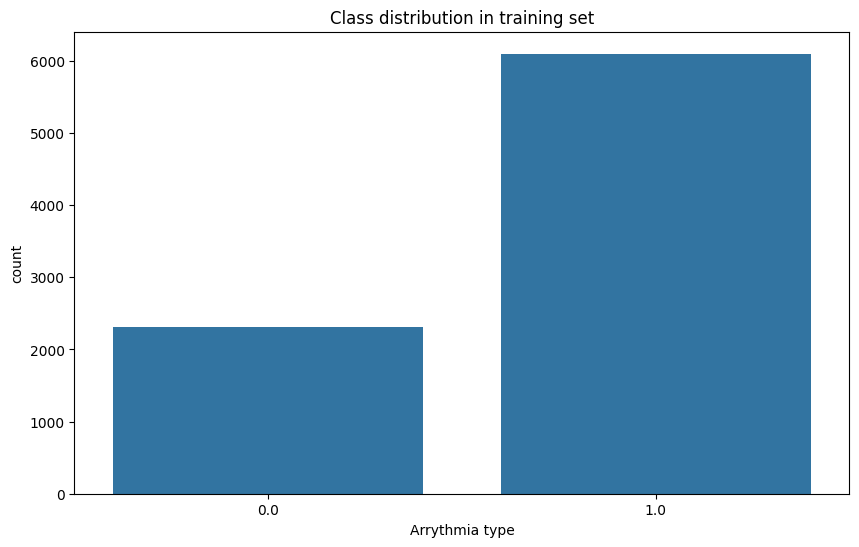

<Figure size 640x480 with 0 Axes>

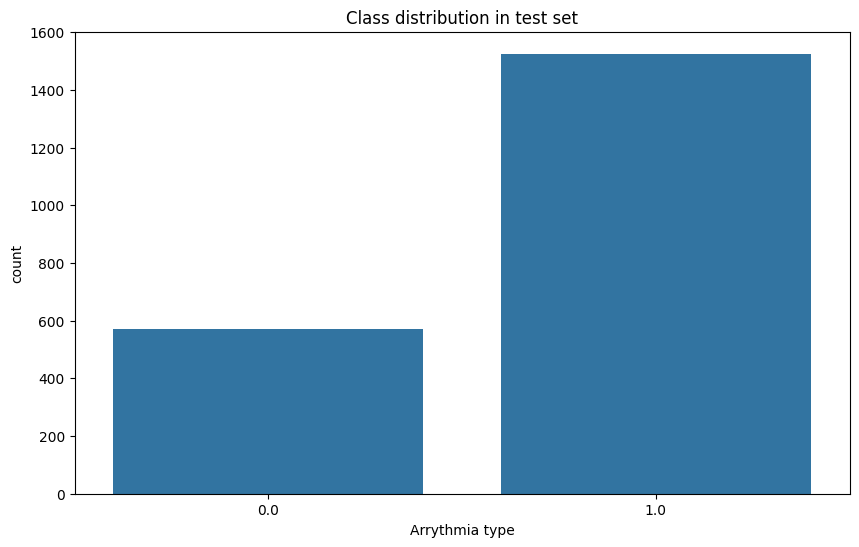

<Figure size 640x480 with 0 Axes>

In [ ]:
check_class_distribution()

### Visualising some examples of heartbeat series

In [ ]:
def visualize_heartbeats():
    X_train, X_test, y_train, y_test = get_dataset('PTB')

    train = pd.concat([X_train, y_train], ignore_index = True, axis = 1).rename(columns = {187: 'Arrythmia type'})
    normal_example = train[train['Arrythmia type'] == 0.0].iloc[2]
    abnormal_example = train[train['Arrythmia type'] == 1.0].iloc[1]

    def plot_series(example : pd.Series, description : String):
        plt.figure(figsize = (10, 6))
        sns.lineplot(data = example.drop('Arrythmia type'))
        plt.title(f'Example of {description} heartbeat series')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.grid(True)
        plt.tight_layout()  # Adjust layout to prevent overlapping labels
        plt.show()
        plt.clf()

    plot_series(normal_example, 'normal')
    plot_series(abnormal_example, 'abnormal')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


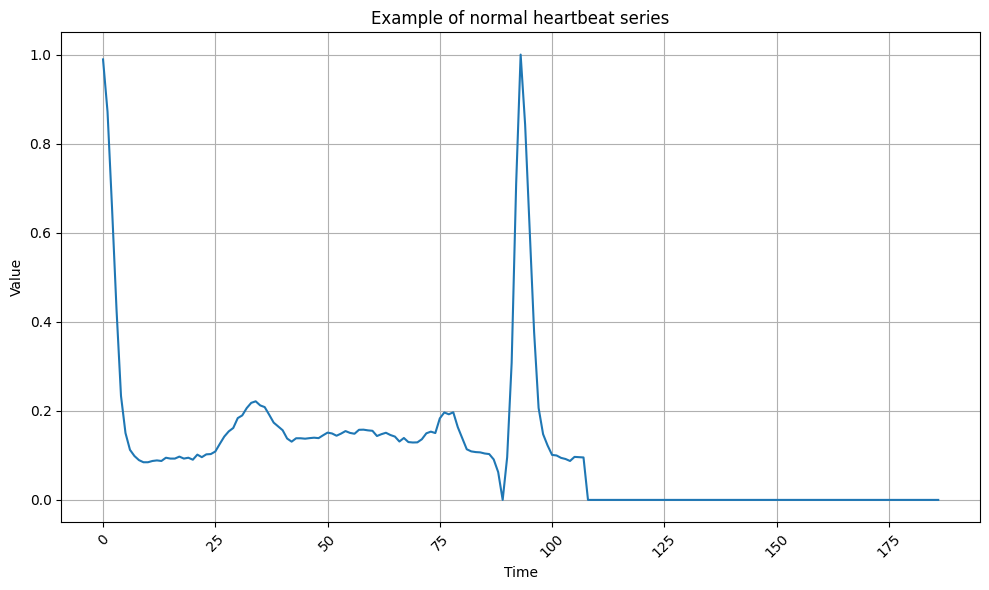

<Figure size 640x480 with 0 Axes>

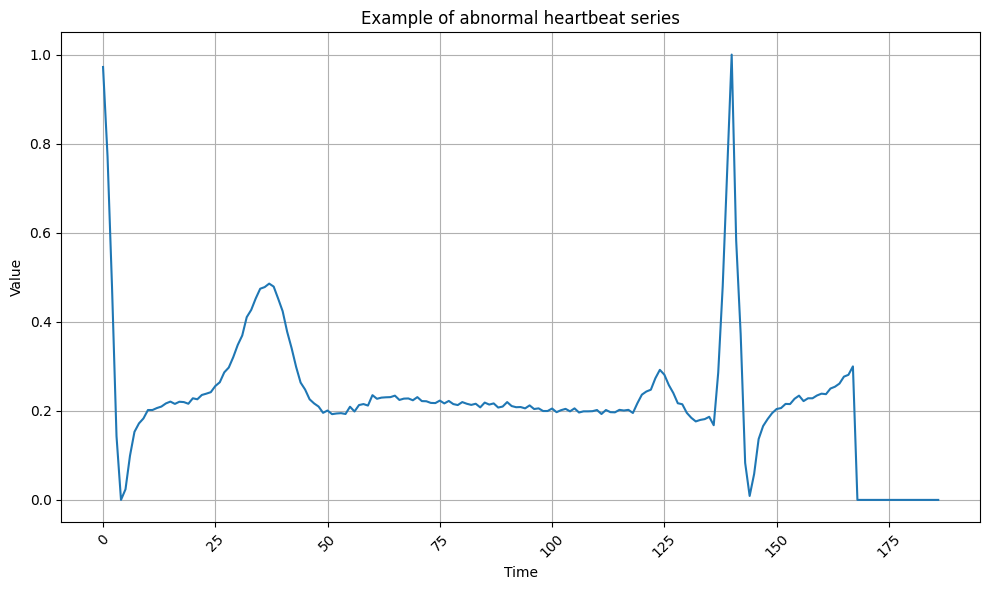

<Figure size 640x480 with 0 Axes>

In [ ]:
visualize_heartbeats()

### Computing mean and standard deviation

In this subsection we are going to compute the mean and standard deviation for each timestamp, per diagnostic class (normal and abnormal).

In [ ]:
def compute_statistics():
    X_train, X_test, y_train, y_test = get_dataset('PTB')

    train = pd.concat([X_train, y_train], ignore_index = True, axis = 1).rename(columns = {187: 'Arrythmia type'})
    test = pd.concat([X_test, y_test], ignore_index = True, axis = 1).rename(columns = {187: 'Arrythmia type'})
    all = pd.concat([train, test], ignore_index = True, axis = 0).rename(columns = {187: 'Arrythmia type'})
    normal = all[all['Arrythmia type'] == 0.0]
    abnormal = all[all['Arrythmia type'] == 1.0]
    normal_mean = normal.mean(axis = 0).iloc[:-1]
    normal_std = normal.std(axis = 0).iloc[:-1]
    normal_stats = pd.concat([normal_mean, normal_std], ignore_index = True, axis = 1).rename(columns = {0: 'mean', 1: 'std'}).T
    abnormal_mean = abnormal.mean(axis = 0).iloc[:-1]
    abnormal_std = abnormal.std(axis = 0).iloc[:-1]
    abnormal_stats = pd.concat([abnormal_mean, abnormal_std], ignore_index = True, axis = 1).rename(columns = {0: 'mean', 1: 'std'}).T

    def plot_mean_std(stats : pd.DataFrame, normal : Bool):
        plt.figure(figsize = (10, 6))
        sns.lineplot(data = stats.loc['mean', :], color = 'blue')
        sns.lineplot(data = stats.loc['std', :], color = 'green')
        plt.title(f'Mean and standard deviation of {"normal" if normal else "abnormal"} heartbeat series')
        plt.xlabel('Time stamp')
        plt.ylabel('Value')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.grid(True)
        plt.tight_layout()  # Adjust layout to prevent overlapping labels
        plt.show()
        plt.clf()

    plot_mean_std(normal_stats, True)
    plot_mean_std(abnormal_stats, False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


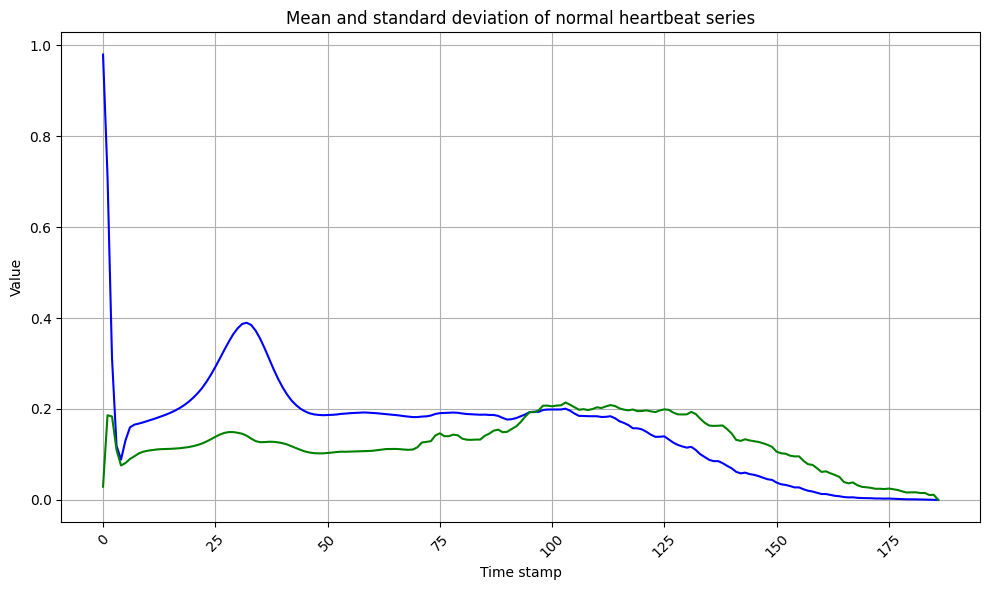

<Figure size 640x480 with 0 Axes>

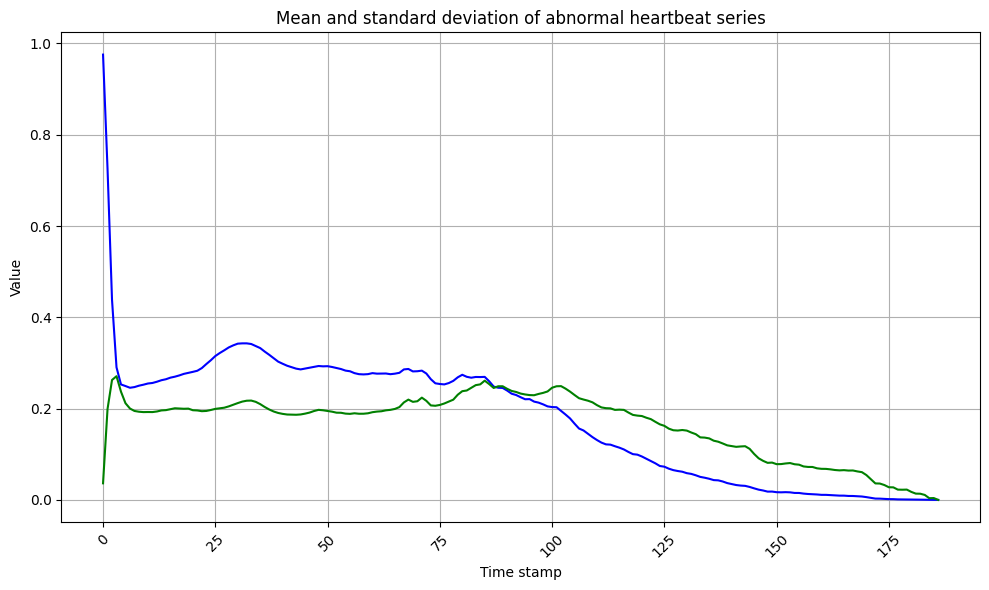

<Figure size 640x480 with 0 Axes>

In [ ]:
compute_statistics()

## Training a MLP neural network

In this section we are going to train a multi-layer perceptron (MLP) neural network, and check out the performance it gets on both datasets.

### Creating the DataLoaders

In order to be able to load the data into the neural network, we need to use DataLoaders.

In [57]:
class TrainDataset(Dataset):
    def __init__(self, data : pd.DataFrame) -> None:
        self.data = [np.array(row.values, dtype = np.double) for _, row in data.iterrows()]

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index : int) -> Tuple[List[np.array], np.array]:
        x = init(self.data[index])
        y = last(self.data[index])
        return x, y

    def get_data(self) -> List[np.array]:
        return self.data

class TestDataset(TrainDataset):
    def __getitem__(self, index : int) -> List[np.array]:
        x = self.data[index]
        return x

In [58]:
X_train, X_test, y_train, y_test = get_dataset('patients')
X_train_1, X_test_1, y_train_1, y_test_1 = get_dataset('PTB')
train_set_patients = TrainDataset(pd.concat([X_train, y_train], ignore_index = True, axis = 1))
test_set_patients = TestDataset(pd.concat([X_test, y_test], ignore_index = True, axis = 1))
train_set_PTB = TrainDataset(pd.concat([X_train_1, y_train_1], ignore_index = True, axis = 1).rename(columns = {187: 'Arrythmia type'}))
test_set_PTB = TrainDataset(pd.concat([X_test_1, y_test_1], ignore_index = True, axis = 1).rename(columns = {187: 'Arrythmia type'}))

BATCH_SIZE = 32
train_loader_patients = DataLoader(train_set_patients, batch_size = BATCH_SIZE, shuffle = True)
test_loader_patients  = DataLoader(test_set_patients, batch_size = BATCH_SIZE, shuffle = False)
train_loader_PTB      = DataLoader(train_set_PTB, batch_size = BATCH_SIZE, shuffle = True)
test_loader_PTB       = DataLoader(test_set_PTB, batch_size = BATCH_SIZE, shuffle = False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Creating the neural network

In [ ]:
class MLP(nn.Module):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def __init__(self, data : DataLoader, input_features : int, num_classes : int, activation) -> None:
        super(MLP, self).__init__()
        self.loader = data
        self.input_features = input_features
        self.num_classes = num_classes
        self.net = nn.Sequential(
            nn.Linear(input_features, 64),
            nn.Linear(64, 32),
            nn.Linear(32, 16),
            nn.Linear(16, 8),
            nn.Linear(8, num_classes),
            activation
        ).to(MLP.device)


    def forward(self, x):
        x = x.type(self.net[0].weight.dtype)
        out = self.net(x)
        return out


    def fit(self, epochs = 10, optimizer = None, criterion = None) -> None:
        if optimizer is None:
            optimizer = torch.optim.SGD(self.parameters(), lr = 1e-4, momentum = 0.9)
        if criterion is None:
            criterion = nn.CrossEntropyLoss()

        self.train()

        for epoch in range(epochs):
            losses = []

            for batch_no, input_data in enumerate(self.loader):
                optimizer.zero_grad()
                x, y = input_data
                x = torch.tensor(x).to(self.device)
                y = torch.tensor(y).to(self.device).long()

                output = self.forward(x)
                loss = criterion(output, y)
                loss.backward()
                losses.append(loss.item())

                optimizer.step()

            if epochs < 50 or (epochs >= 50 and (epoch + 1) % 10 == 0):
                print('Epoch %d | Loss %6.2f' % (epoch + 1, sum(losses) / len(losses)))


    def predict(self, test_data : DataLoader) -> None:
        self.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for t in test_data:
                x = torch.tensor(np.array(t[:-1])).to(MLP.device)
                y = torch.tensor(t[-1]).to(MLP.device)
                raw_output = self.forward(x)
                if raw_output.dim() > 1:
                    output = raw_output.argmax(dim = 1)
                    output = output.squeeze()
                else:
                    output = raw_output.argmax(dim = 0)
                all_preds.append(output.cpu().numpy())
                all_labels.append(y.cpu().numpy())

        all_preds = np.array(all_preds, dtype = int)
        all_labels = np.array(all_labels, dtype = int)

        # Print classification report
        print('Classification report:\n')
        print(classification_report(all_labels, all_preds, digits = 4))
        # Print confusion matrix
        print('Confusion matrix:\n')
        matrix = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix = matrix)
        disp.plot()
        plt.show()

    def fit_predict(self, epochs = 10, optimizer = None, criterion = None, test_data : Optional[DataLoader] = None) -> None:
        if optimizer is None:
            optimizer = torch.optim.SGD(self.parameters(), lr = 1e-4, momentum = 0.9)
        if criterion is None:
            criterion = nn.CrossEntropyLoss()

        avg_losses = []
        test_losses_1 = []
        for _ in range(epochs):
            self.train()
            losses = []

            for batch_no, input_data in enumerate(self.loader):
                optimizer.zero_grad()
                x, y = input_data
                x = torch.tensor(x).to(self.device)
                y = torch.tensor(y).to(self.device).long()

                output = self.forward(x)
                loss = criterion(output, y)
                loss.backward()
                losses.append(loss.item())

                optimizer.step()

            avg_losses.append(sum(losses) / len(losses))
            self.eval()
            test_losses = []

            with torch.no_grad():
                for t in test_data:
                    x = torch.tensor(np.array(t[:-1])).to(MLP.device)
                    y = torch.tensor(t[-1]).to(MLP.device).long()
                    raw_output = self.forward(x).float()
                    if raw_output.dim() > 1:
                        raw_output = raw_output.squeeze()
                    loss = criterion(raw_output, y)
                    test_losses.append(loss.item())

            test_losses_1.append(sum(test_losses) / len(test_losses))

        # Plot train and test losses
        plt.figure(figsize = (15, 9))
        plt.plot(avg_losses, label = 'Train loss', color = 'red')
        plt.plot(test_losses_1, label = 'Test loss', color = 'green')
        plt.title('Train and test loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.clf()


### Training and testing the network

Epoch 10 | Loss   0.85
Epoch 20 | Loss   0.76
Epoch 30 | Loss   0.70
Epoch 40 | Loss   0.66
Epoch 50 | Loss   0.63
Epoch 60 | Loss   0.61
Epoch 70 | Loss   0.60
Epoch 80 | Loss   0.59
Epoch 90 | Loss   0.58
Epoch 100 | Loss   0.57
Epoch 110 | Loss   0.57
Epoch 120 | Loss   0.56
Epoch 130 | Loss   0.56
Epoch 140 | Loss   0.55
Epoch 150 | Loss   0.55
Epoch 160 | Loss   0.54
Epoch 170 | Loss   0.54
Epoch 180 | Loss   0.54
Epoch 190 | Loss   0.53
Epoch 200 | Loss   0.53
Classification report:

              precision    recall  f1-score   support

           0     0.7636    0.8571    0.8077        49
           1     0.6923    0.6792    0.6857        53
           2     0.6863    0.6731    0.6796        52
           3     0.8485    0.5185    0.6437        54
           4     0.7125    0.8906    0.7917        64
           5     0.9245    0.9074    0.9159        54
           6     0.9672    1.0000    0.9833        59

    accuracy                         0.7948       385
   macro avg     

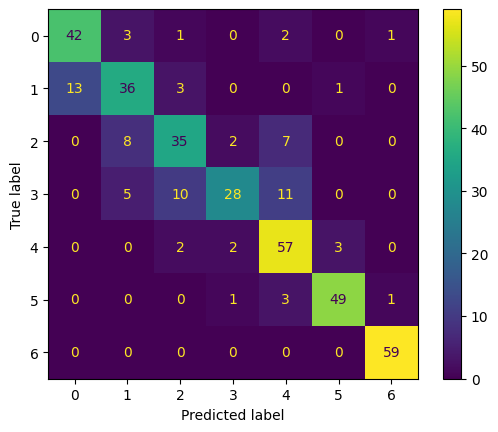

In [ ]:
# Evaluating the network on the 'patients' dataset
model = MLP(train_set_patients, 18, 7, nn.LeakyReLU()).to(MLP.device)
model.fit(epochs = 200, optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4, weight_decay = 1e-4))
model.predict(test_set_patients)

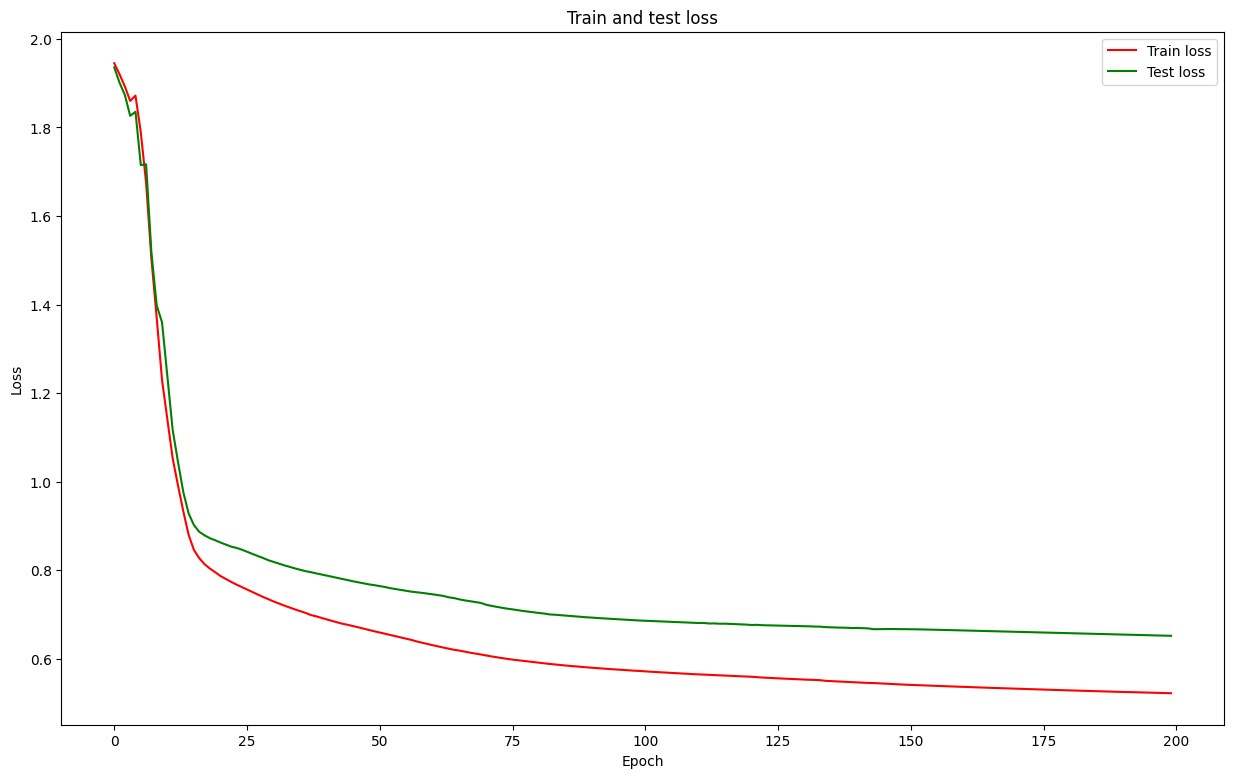

<Figure size 640x480 with 0 Axes>

In [ ]:
model = MLP(train_set_patients, 18, 7, nn.LeakyReLU()).to(MLP.device)
model.fit_predict(epochs = 200, optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4, weight_decay = 1e-4), test_data = test_set_patients)

Epoch 1 | Loss   0.50
Epoch 2 | Loss   0.44
Epoch 3 | Loss   0.43
Epoch 4 | Loss   0.42
Epoch 5 | Loss   0.42
Epoch 6 | Loss   0.41
Epoch 7 | Loss   0.41
Epoch 8 | Loss   0.40
Epoch 9 | Loss   0.40
Epoch 10 | Loss   0.39
Classification report:

              precision    recall  f1-score   support

           0     0.7262    0.5834    0.6470       809
           1     0.8510    0.9153    0.8820      2102

    accuracy                         0.8231      2911
   macro avg     0.7886    0.7494    0.7645      2911
weighted avg     0.8163    0.8231    0.8167      2911

Confusion matrix:



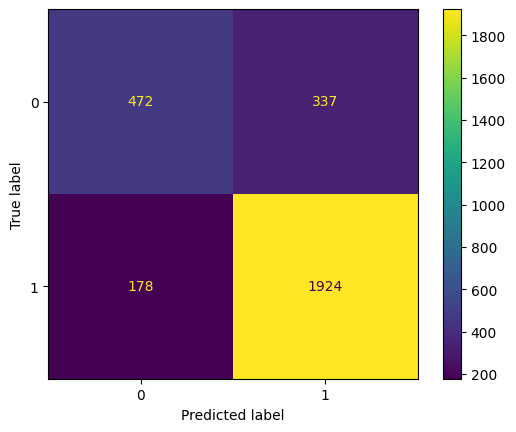

In [ ]:
# Evaluating the network on the 'PTB' dataset
model1 = MLP(train_set_PTB, 187, 2, nn.Tanh()).to(MLP.device)
model1.fit(optimizer = torch.optim.SGD(model1.parameters(), lr = 5e-4, momentum = 0.9))
model1.predict(test_set_PTB)

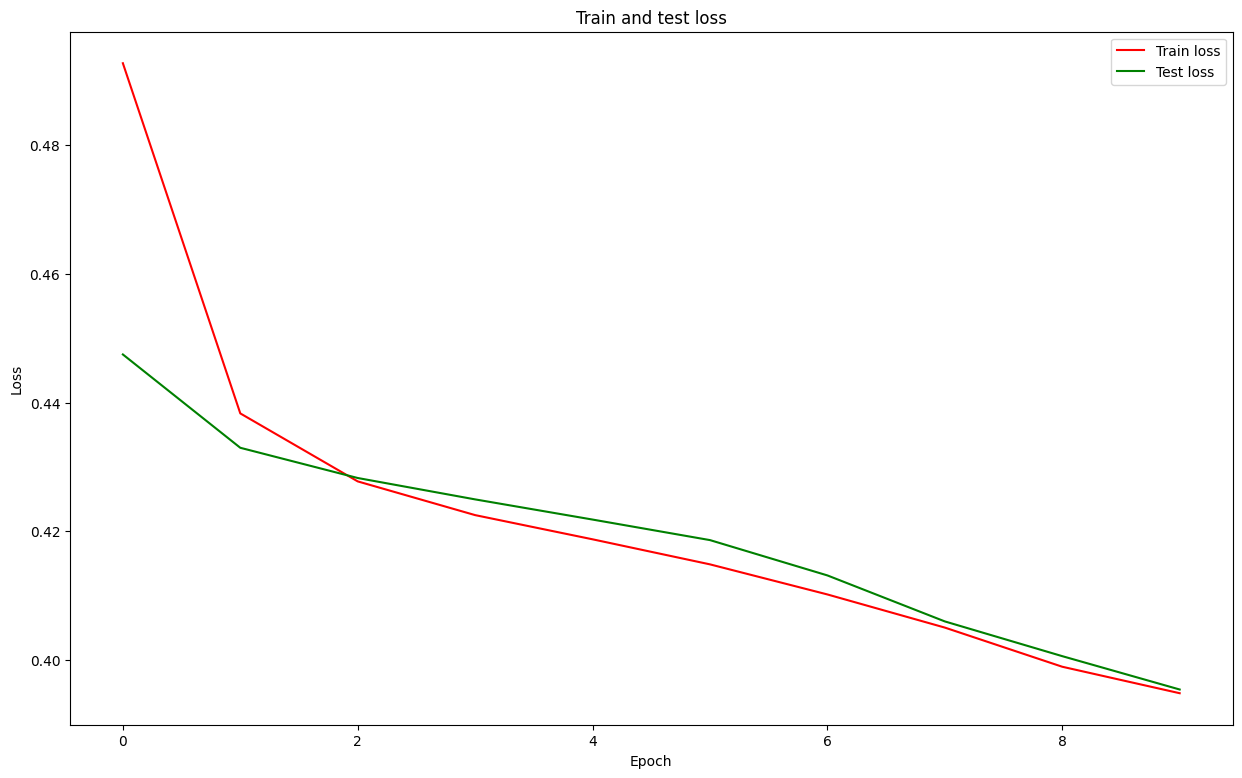

<Figure size 640x480 with 0 Axes>

In [ ]:
model1 = MLP(train_set_PTB, 187, 2, nn.Tanh()).to(MLP.device)
model1.fit_predict(optimizer = torch.optim.SGD(model1.parameters(), lr = 5e-4, momentum = 0.9), test_data = test_set_PTB)

## Training a convolutional neural network

In this section, we are going to create a convolutional neural network (CNN), and train and test it on the `PTB Diagnostic ECG` dataset.

### Creating the network

In [61]:
class ConvNet(nn.Module):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def __init__(self, data : DataLoader, input_features : int, num_classes : int) -> None:
        super(ConvNet, self).__init__()
        self.loader = data
        self.input_features = input_features
        self.num_classes = num_classes
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size = 2),
            nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size = 2),
            nn.Flatten(),
            nn.Linear(64 * (input_features // 4), 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        ).to(ConvNet.device)


    def forward(self, x):
        x = x.type(self.net[0].weight.dtype)
        out = self.net(x)
        return out


    def fit(self, epochs = 10, optimizer = None, criterion = None) -> None:
        if optimizer is None:
            optimizer = torch.optim.SGD(self.parameters(), lr = 1e-4, momentum = 0.9)
        if criterion is None:
            criterion = nn.CrossEntropyLoss()

        self.train()

        for epoch in range(epochs):
            losses = []

            for batch_no, input_data in enumerate(self.loader):
                optimizer.zero_grad()
                x, y = input_data
                x = torch.tensor(x).to(self.device)
                x = x.view(-1, 1, self.input_features)
                y = torch.tensor(y).to(self.device).unsqueeze(0).long()

                output = self.forward(x)
                loss = criterion(output, y)
                loss.backward()
                losses.append(loss.item())

                optimizer.step()

            print('Epoch %d | Loss %6.2f' % (epoch + 1, sum(losses) / len(losses)))


    def predict(self, test_data : DataLoader) -> None:
        self.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for t in test_data:
                x = torch.tensor(np.array(t[:-1])).to(self.device)
                x = x.view(-1, 1, self.input_features)
                y = torch.tensor(t[-1]).to(self.device)
                raw_output = self.forward(x)
                if raw_output.dim() > 1:
                    output = raw_output.argmax(dim = 1)
                    output = output.squeeze()
                else:
                    output = raw_output.argmax(dim = 0)
                all_preds.append(output.cpu().numpy())
                all_labels.append(y.cpu().numpy())

        all_preds = np.array(all_preds, dtype = int)
        all_labels = np.array(all_labels, dtype = int)

        # Print classification report
        print('Classification report:\n')
        print(classification_report(all_labels, all_preds, digits = 4))
        # Print confusion matrix
        print('Confusion matrix:\n')
        matrix = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix = matrix)
        disp.plot()
        plt.show()

    def fit_predict(self, epochs = 10, optimizer = None, criterion = None, test_data : Optional[DataLoader] = None) -> None:
        if optimizer is None:
            optimizer = torch.optim.SGD(self.parameters(), lr = 1e-4, momentum = 0.9)
        if criterion is None:
            criterion = nn.CrossEntropyLoss()

        avg_losses = []
        test_losses_1 = []
        for _ in range(epochs):
            self.train()
            losses = []

            for batch_no, input_data in enumerate(self.loader):
                optimizer.zero_grad()
                x, y = input_data
                x = torch.tensor(x).to(self.device)
                x = x.view(-1, 1, self.input_features)
                y = torch.tensor(y).to(self.device).unsqueeze(0).long()

                output = self.forward(x)
                loss = criterion(output, y)
                loss.backward()
                losses.append(loss.item())

                optimizer.step()

            avg_losses.append(sum(losses) / len(losses))
            self.eval()
            test_losses = []

            with torch.no_grad():
                for t in test_data:
                    x = torch.tensor(np.array(t[:-1])).to(self.device)
                    x = x.view(-1, 1, self.input_features)
                    y = torch.tensor(t[-1]).to(self.device).long()
                    raw_output = self.forward(x).float()
                    if raw_output.dim() > 1:
                        raw_output = raw_output.squeeze()
                    loss = criterion(raw_output, y)
                    test_losses.append(loss.item())

            test_losses_1.append(sum(test_losses) / len(test_losses))

        # Plot train and test losses
        plt.figure(figsize = (15, 9))
        plt.plot(avg_losses, label = 'Train loss', color = 'red')
        plt.plot(test_losses_1, label = 'Test loss', color = 'green')
        plt.title('Train and test loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.clf()

### Training and testing the network

Epoch 1 | Loss   0.43
Epoch 2 | Loss   0.33
Epoch 3 | Loss   0.28
Epoch 4 | Loss   0.23
Epoch 5 | Loss   0.20
Epoch 6 | Loss   0.17
Epoch 7 | Loss   0.15
Epoch 8 | Loss   0.13
Epoch 9 | Loss   0.12
Epoch 10 | Loss   0.11
Epoch 11 | Loss   0.10
Epoch 12 | Loss   0.09
Epoch 13 | Loss   0.08
Epoch 14 | Loss   0.08
Epoch 15 | Loss   0.07
Classification report:

              precision    recall  f1-score   support

           0     0.9175    0.9481    0.9325       809
           1     0.9798    0.9672    0.9734      2102

    accuracy                         0.9619      2911
   macro avg     0.9486    0.9576    0.9530      2911
weighted avg     0.9624    0.9619    0.9621      2911

Confusion matrix:



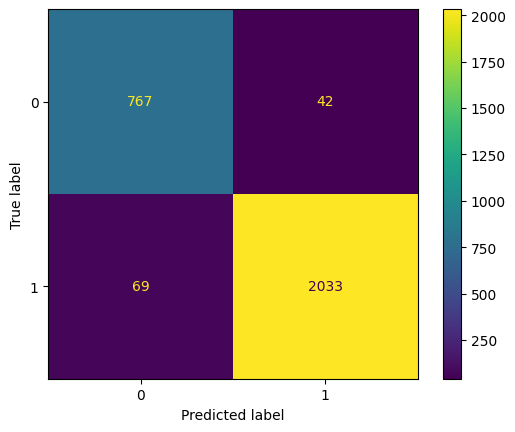

In [62]:
model2 = ConvNet(train_set_PTB, 187, 2).to(ConvNet.device)
model2.fit(epochs = 15, optimizer = torch.optim.SGD(model2.parameters(), lr = 5e-4, momentum = 0.9))
model2.predict(test_set_PTB)

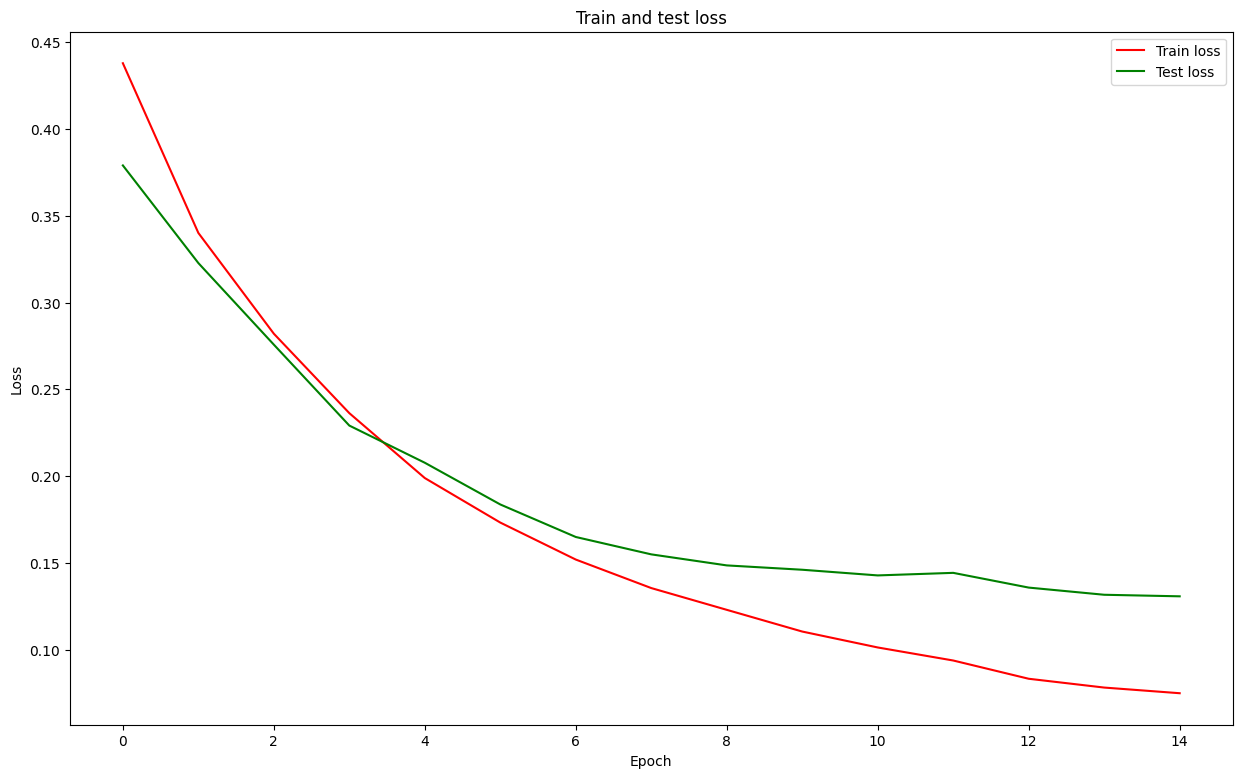

<Figure size 640x480 with 0 Axes>

In [63]:
model2 = ConvNet(train_set_PTB, 187, 2).to(ConvNet.device)
model2.fit_predict(epochs = 15, optimizer = torch.optim.SGD(model2.parameters(), lr = 5e-4, momentum = 0.9), test_data = test_set_PTB)